Avg Amplified Voltage: 0.00V, Avg Sent Voltage: 4.67V, Gain: 0.00, Offset: 22.00


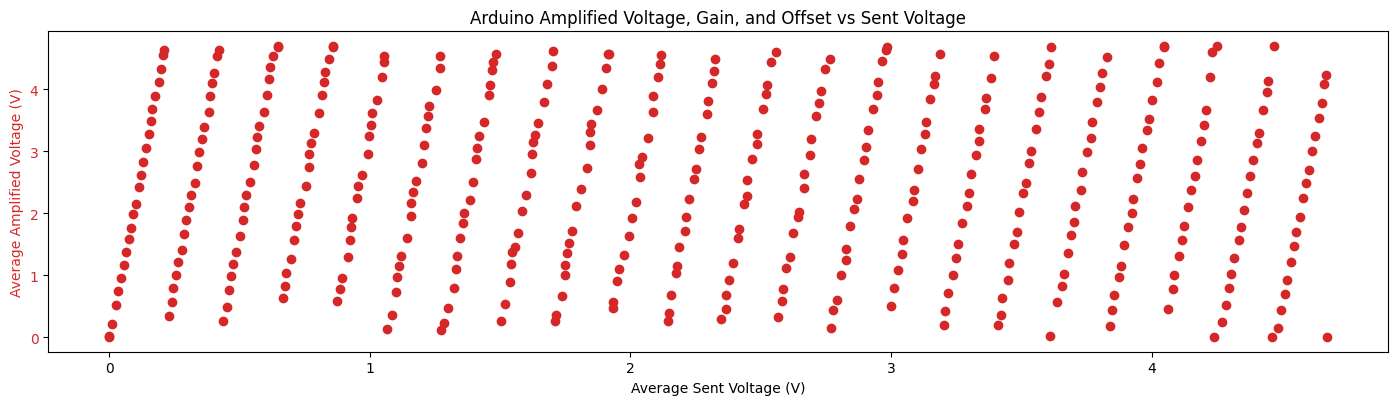

In [24]:
import serial
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Set up serial communication
ser = serial.Serial('COM8', 115200, timeout=1)
time.sleep(2)  # Wait for the serial connection to initialize

amplified_voltages = []
sent_voltages = []
gains = []
offsets = []

try:
    for i in range(0, 4096, 10):
        ser.write(str(i).encode())  # Send the PWM value to the Arduino
        first_offset = None
        valid_amplified_voltage_readings = []
        valid_sent_voltage_readings = []

        for _ in range(10):
            ser.flush()
            line = ser.readline().decode('utf-8').strip()
            parts = line.split(',')
            if len(parts) == 3:  # Check if there are 3 parts in the line
                try:
                    amplified_voltage_str, sent_voltage_str, offset_str = parts
                    amplified_voltage = float(amplified_voltage_str.split(':')[1])
                    sent_voltage = float(sent_voltage_str.split(':')[1])
                    offset = float(offset_str.split(':')[1])  # Parse the offset value

                    if first_offset is None:
                        first_offset = offset
                    if offset == first_offset:
                        valid_amplified_voltage_readings.append(amplified_voltage)
                        valid_sent_voltage_readings.append(sent_voltage)

                except ValueError:
                    continue
            time.sleep(0.1)

        avg_amplified_voltage = sum(valid_amplified_voltage_readings) / len(valid_amplified_voltage_readings) if valid_amplified_voltage_readings else 0
        avg_sent_voltage = sum(valid_sent_voltage_readings) / len(valid_sent_voltage_readings) if valid_sent_voltage_readings else 0

        amplified_voltages.append(avg_amplified_voltage)
        sent_voltages.append(avg_sent_voltage)
        offsets.append(first_offset)  # Add first offset to the list

        gain = avg_amplified_voltage / avg_sent_voltage if avg_sent_voltage != 0 else 0
        gains.append(gain)

        clear_output(wait=True)
        print(f"Avg Amplified Voltage: {avg_amplified_voltage:.2f}V, Avg Sent Voltage: {avg_sent_voltage:.2f}V, Gain: {gain:.2f}, Offset: {first_offset:.2f}")

        # Clear the previous plot
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('Average Sent Voltage (V)')
        ax1.set_ylabel('Average Amplified Voltage (V)', color=color)
        ax1.plot(sent_voltages, amplified_voltages, 'o', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # ax2 = ax1.twinx()
        # color = 'tab:blue'
        # ax2.set_ylabel('Gain and Offset', color=color)
        # ax2.plot(sent_voltages, offsets, '+', color='tab:green')
        # ax2.tick_params(axis='y', labelcolor=color)

        plt.title('Arduino Amplified Voltage, Gain, and Offset vs Sent Voltage')
        fig.tight_layout()
        fig.set_size_inches(15, 4)
        
        display(plt.gcf())  # Display the current figure
        plt.close(fig)  # Close the figure to prevent duplicate plots

except KeyboardInterrupt:
    print("Program interrupted by the user")

finally:
    
    ser.write(str(0).encode())
    ser.close()


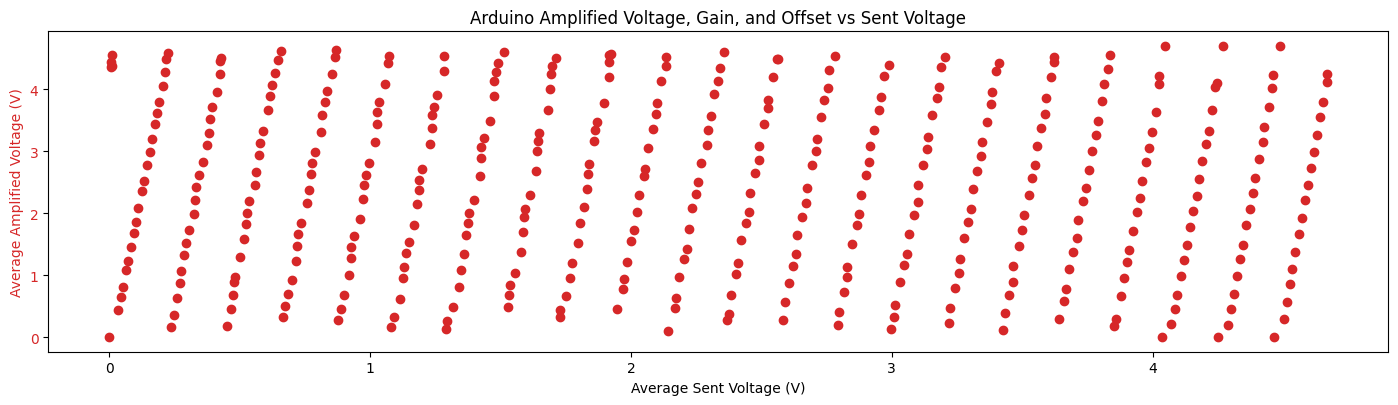

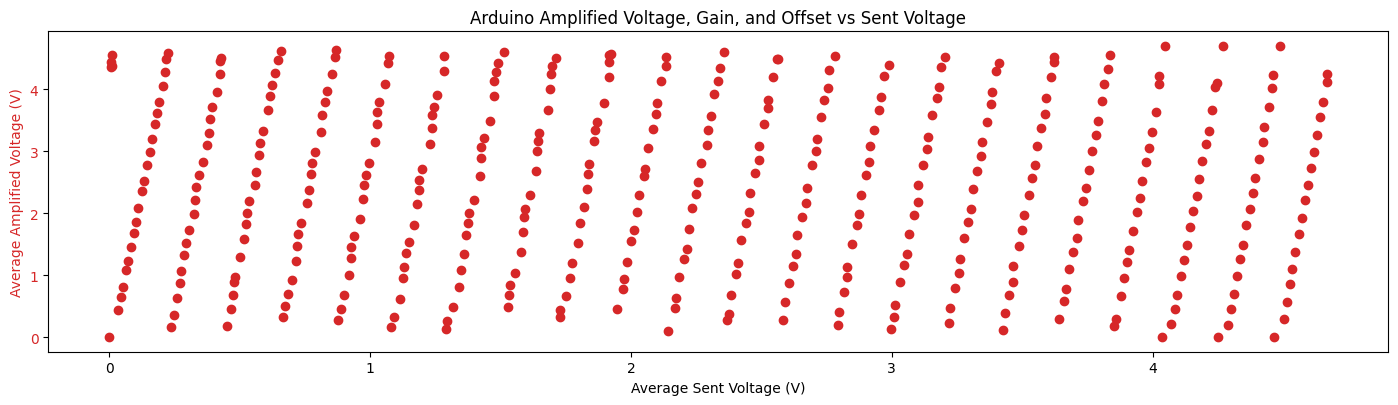

In [6]:
# Clear the previous plot
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Average Sent Voltage (V)')
ax1.set_ylabel('Average Amplified Voltage (V)', color=color)
ax1.plot(sent_voltages, amplified_voltages, 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:blue'
# ax2.set_ylabel('Gain and Offset', color=color)
# ax2.plot(sent_voltages, offsets, '+', color='tab:green')
# ax2.tick_params(axis='y', labelcolor=color)

plt.title('Arduino Amplified Voltage, Gain, and Offset vs Sent Voltage')
fig.tight_layout()
fig.set_size_inches(15, 4)

display(plt.gcf())  # Display the current figure

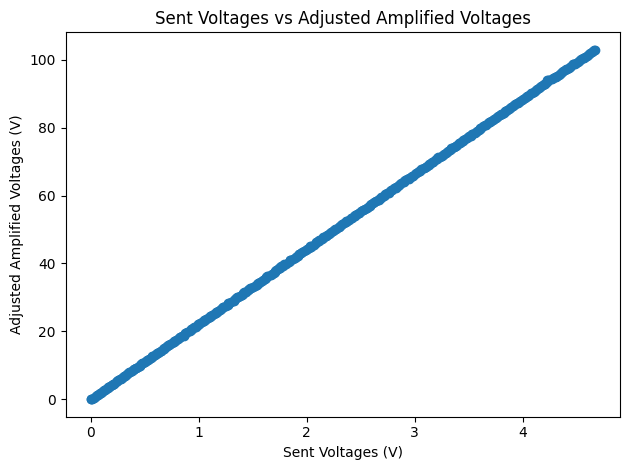

In [25]:
# Assuming sent_voltages, amplified_voltages, and offsets are already populated lists
adjusted_amplified_voltages = []
filtered_sent_voltages = []

# Loop through the lists and adjust the amplified voltages
for i in range(len(offsets)-1):
    if offsets[i].is_integer():  # Check if the offset is an integer
        adjusted_offset = offsets[i] * (4.7)
        adjusted_amplified_voltage = amplified_voltages[i] + adjusted_offset
        adjusted_amplified_voltages.append(adjusted_amplified_voltage)
        filtered_sent_voltages.append(sent_voltages[i])

# Plotting
fig, ax = plt.subplots()
ax.plot(filtered_sent_voltages, adjusted_amplified_voltages, 'o', color='tab:blue')
ax.set_xlabel('Sent Voltages (V)')
ax.set_ylabel('Adjusted Amplified Voltages (V)')
plt.title('Sent Voltages vs Adjusted Amplified Voltages')
fig.tight_layout()

display(plt.gcf())
plt.close(fig)

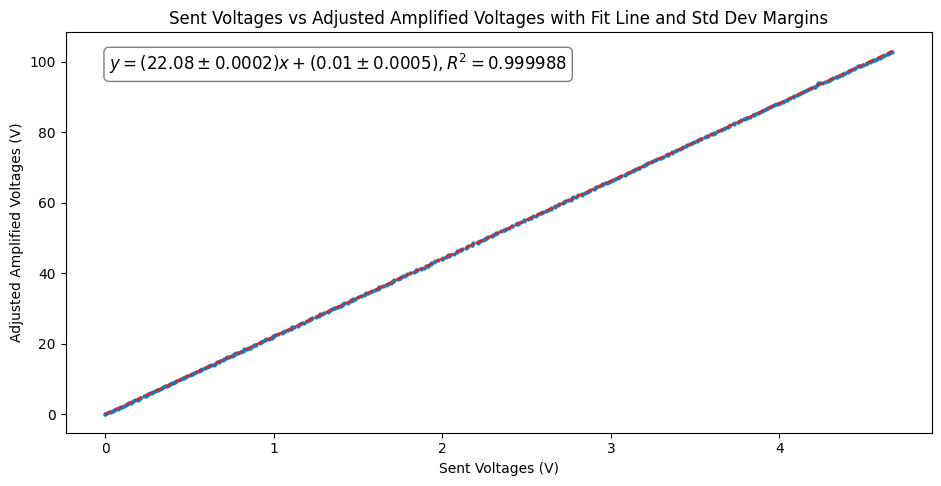

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Assuming sent_voltages, amplified_voltages, and offsets are already populated lists
# ... [Your existing code for calculating adjusted_amplified_voltages and filtered_sent_voltages] ...

# Linear Fit
slope, intercept = np.polyfit(filtered_sent_voltages, adjusted_amplified_voltages, 1)
fit_line = np.polyval([slope, intercept], filtered_sent_voltages)

# Calculate Standard Deviation of Fit Residuals
residuals = adjusted_amplified_voltages - np.polyval([slope, intercept], filtered_sent_voltages)
std_dev = np.std(residuals)

# Calculate the standard deviations for slope and intercept
# Polyfit doesn't directly provide std dev for slope and intercept, so we approximate
# using the residuals and the number of data points
n = len(filtered_sent_voltages)
std_err = std_dev / np.sqrt(n)
std_dev_slope = std_err * np.sqrt(n / (n*np.sum(np.array(filtered_sent_voltages)**2) - np.sum(filtered_sent_voltages)**2))
std_dev_intercept = std_err * np.sqrt(np.sum(np.array(filtered_sent_voltages)**2) / (n*np.sum(np.array(filtered_sent_voltages)**2) - np.sum(filtered_sent_voltages)**2))

# Calculate R-squared
ss_res = np.sum(residuals**2)
ss_tot = np.sum((adjusted_amplified_voltages - np.mean(adjusted_amplified_voltages))**2)
r_squared = 1 - (ss_res / ss_tot)

# Equation in LaTeX with std dev and R-squared, with linebreak
equation = r'$y = ({:.2f} \pm {:.4f})x + ({:.2f} \pm {:.4f}),$' \
           r'$R^2 = {:.6f}$'.format(slope, std_dev_slope, intercept, std_dev_intercept, r_squared)

# Plotting
fig, ax = plt.subplots()
ax.plot(filtered_sent_voltages, adjusted_amplified_voltages, 'o', color='tab:blue', label='Data', markersize=2)  # Smaller points
ax.plot(filtered_sent_voltages, fit_line, '--', color='tab:red', label='Fit Line')  # Dashed line

# Plot std deviation margins
ax.fill_between(filtered_sent_voltages, fit_line - std_dev, fit_line + std_dev, color='tab:orange', alpha=0.2, label='Std Dev Margin')

ax.set_xlabel('Sent Voltages (V)')
ax.set_ylabel('Adjusted Amplified Voltages (V)')
plt.title('Sent Voltages vs Adjusted Amplified Voltages with Fit Line and Std Dev Margins')

# Display the equation on the plot
ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# ax.legend()
fig.tight_layout()
fig.set_size_inches(10, 5)

display(plt.gcf())
plt.close(fig)


In [64]:
import serial
import pandas as pd
import time

# Set up the serial connection (adjust the port and baud rate according to your setup)
ser = serial.Serial('COM8', 115200, timeout=1)
time.sleep(2)  # Wait for the connection to be established

# DataFrame to store the results
df = pd.DataFrame(columns=['Time', 'AmplifiedVoltage', 'AppliedOffset'])

try:
    while True:
        # Send the "$" character
        ser.write(b'$')
        
        # Read the line from the serial
        line = ser.readline().decode('utf-8').strip()

        # Parse the line and add it to the DataFrame
        if line.startswith('Amplified:'):
            parts = line.split(',')
            if len(parts) >= 2:
                try:
                    amplified_voltage = float(parts[0].split(':')[1])
                    applied_offset = float(parts[1].split(':')[1])

                    # Create a new DataFrame for the row and concatenate it
                    new_row = pd.DataFrame({'Time': [time.time()],
                                            'AmplifiedVoltage': [amplified_voltage],
                                            'AppliedOffset': [applied_offset]})
                    df = pd.concat([df, new_row], ignore_index=True)
                except ValueError:
                    print(f"Error parsing line: {line}")
            else:
                print(f"Incomplete data: {line}")

        # Wait for 1 second
        time.sleep(1)

except KeyboardInterrupt:
    # Close the serial connection and show the DataFrame
    ser.close()
    print(df)

# Optional: Save the DataFrame to a CSV file
# df.to_csv('log.csv', index=False)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4572\1324904967.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


             Time  AmplifiedVoltage  AppliedOffset
0    1.702780e+09              3.05           0.92
1    1.702780e+09              0.68           0.91
2    1.702780e+09              3.05           0.92
3    1.702780e+09              0.68           0.91
4    1.702780e+09              3.04           0.92
..            ...               ...            ...
678  1.702780e+09              0.66           0.93
679  1.702780e+09              3.00           0.94
680  1.702780e+09              0.65           0.93
681  1.702780e+09              3.01           0.94
682  1.702780e+09              0.65           0.93

[683 rows x 3 columns]


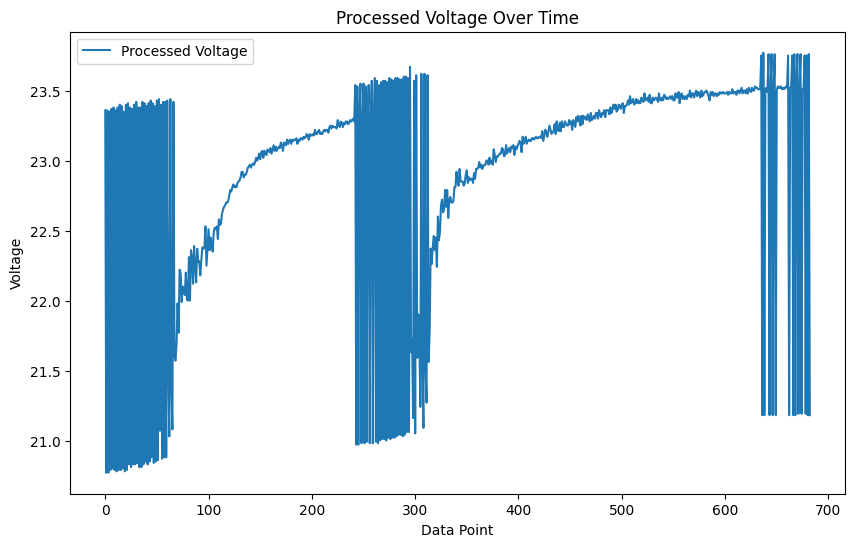

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

# Perform the calculation
df['ProcessedVoltage'] = df['AppliedOffset'] * 22.08 + df['AmplifiedVoltage']

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(df['ProcessedVoltage'], label='Processed Voltage')
plt.xlabel('Data Point')
plt.ylabel('Voltage')
plt.title('Processed Voltage Over Time')
plt.legend()
plt.show()
